     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 14.3 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-1-5c573a10e270>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subjects, y=values, palette='viridis')


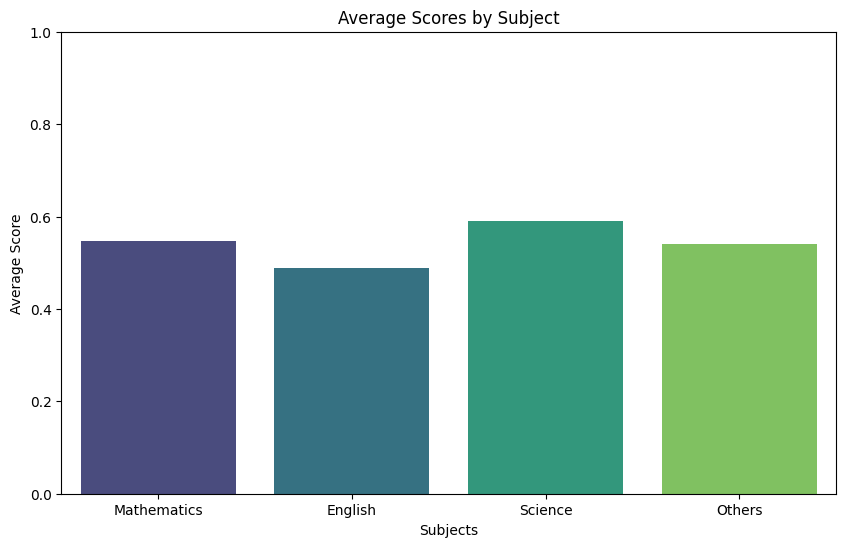

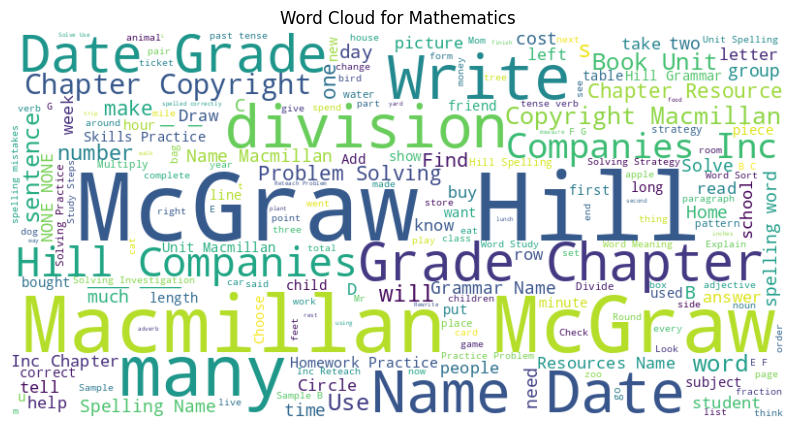

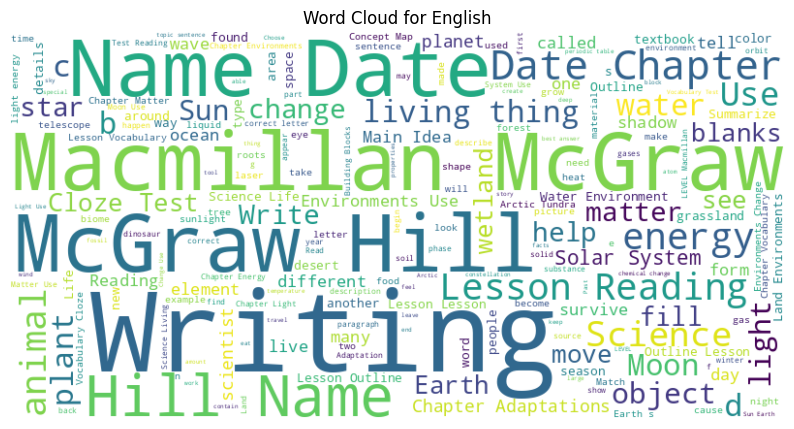

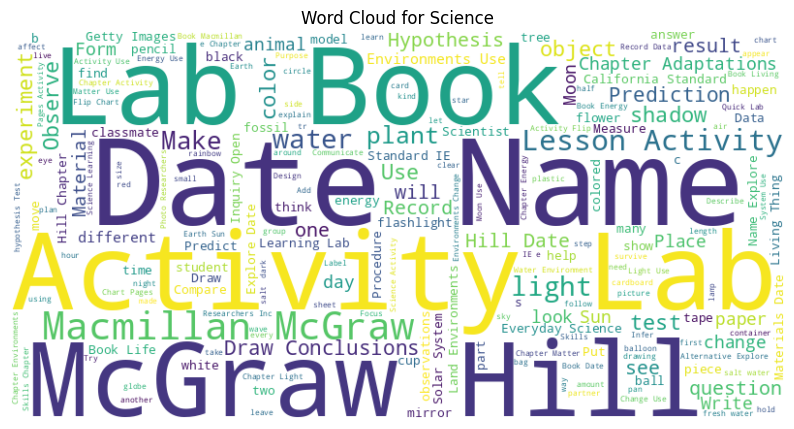

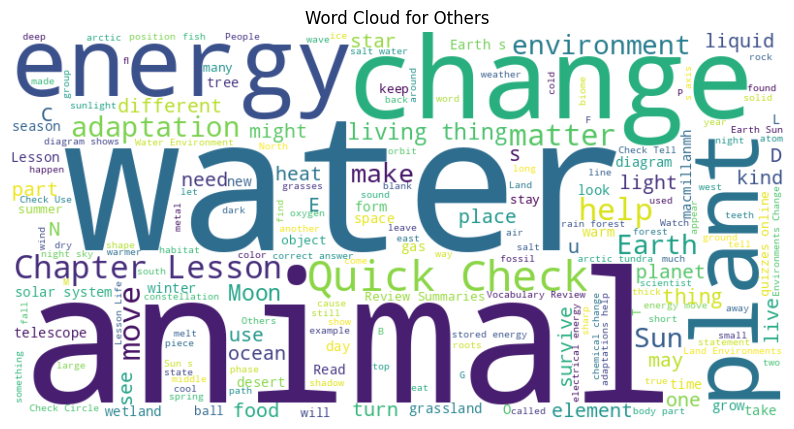

In [1]:
# Install required libraries
!pip install PyMuPDF wordcloud matplotlib seaborn

import fitz  # PyMuPDF
import re
import os
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Mount Google Drive to access Colab storage
drive.mount('/content/drive')

# Directory containing PDFs
pdf_directory = '/content/drive/MyDrive/CapstoneData'

# Function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    pdf_document = fitz.open(pdf_path)
    text_data = []
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        text = page.get_text()
        text_data.append(text)
    full_text = "\n".join(text_data)
    return full_text

# Function to preprocess the extracted text
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    chapters = text.split('CHAPTER')
    return chapters

# Function to classify text into subjects
def classify_subject(text):
    if re.search(r'\b(math|algebra|geometry|calculus)\b', text, re.IGNORECASE):
        return 'Mathematics'
    elif re.search(r'\b(english|literature|grammar|reading|writing)\b', text, re.IGNORECASE):
        return 'English'
    elif re.search(r'\b(science|biology|chemistry|physics)\b', text, re.IGNORECASE):
        return 'Science'
    else:
        return 'Others'

# Function to score text based on criteria
def score_text(text):
    length_score = min(len(text) / 1000, 1)  # Normalized score based on text length
    complexity_score = 1 - len(re.findall(r'\b(\w+)\b', text)) / len(text.split())  # Inverse of word complexity
    return length_score * 0.5 + complexity_score * 0.5  # Weighted score

# Initialize dictionaries to hold the scores for each subject
scores = {'Mathematics': [], 'English': [], 'Science': [], 'Others': []}

# Loop through each PDF file in the directory and process the text
for filename in os.listdir(pdf_directory):
    if filename.endswith('.pdf'):
        pdf_path = os.path.join(pdf_directory, filename)
        full_text = extract_text_from_pdf(pdf_path)
        preprocessed_text = preprocess_text(full_text)
        for chapter in preprocessed_text:
            subject = classify_subject(chapter)
            score = score_text(chapter)
            scores[subject].append(score)

# Calculate average scores for each subject
average_scores = {subject: sum(scores_list) / len(scores_list) if scores_list else 0
                  for subject, scores_list in scores.items()}

# Plot average scores
def plot_average_scores(scores):
    subjects = list(scores.keys())
    values = list(scores.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=subjects, y=values, palette='viridis')
    plt.xlabel('Subjects')
    plt.ylabel('Average Score')
    plt.title('Average Scores by Subject')
    plt.ylim(0, 1)
    plt.show()

# Plot the average scores
plot_average_scores(average_scores)

# Extract text for word clouds
def extract_text_by_subject(directory, subject_filter):
    all_text = ''
    for filename in os.listdir(directory):
        if filename.endswith('.pdf'):
            pdf_path = os.path.join(directory, filename)
            full_text = extract_text_from_pdf(pdf_path)
            preprocessed_text = preprocess_text(full_text)
            for chapter in preprocessed_text:
                subject = classify_subject(chapter)
                if subject == subject_filter:
                    all_text += ' ' + chapter
    return all_text

# Generate and plot word clouds
def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word clouds for each subject
subjects = ['Mathematics', 'English', 'Science', 'Others']
for subject in subjects:
    text = extract_text_by_subject(pdf_directory, subject)
    plot_word_cloud(text, f'Word Cloud for {subject}')
